# Predicting Stock Prices using Long Short-Term Memory (LSTM)

In this notebook, we will try to predict Tesla stock prices using LSTM models. LSTMs are a special kind of Recurrent Neural Network (RNN) introduced by Hochreiter and Schmidhuber (1997). They are widely used to learn long term dependencies.

First, we upload and preprocess data. Then, we implement a Vanilla LSTM model to predict one day into the future. Finally, we study a multi-Step LSTM to predict several days into the future.

Very useful links are provided at the end of the notebook. Those links will help you go through simple data processing and LSTMs.

### Summary
* [1. Data Preprocessing](#chapter1)
    * [a. Upload and plot data](#section_1_1)
    * [b. Checking stationarity](#Section_1_2)
    * [c. Making our time series stationary](#Section_1_3)
* [2. LSTM](#chapter2)
    * [a. Preprocessing again for LSTM](#section_2_1)
    * [b. Split Data (train set and test set)](#section_2_2)
    * [c. Implementing the model](#section_2_3)
    * [d. Training and evaluating the model](#section_2_4)
    * [e. Predictions](#section_2_5)
* [3. Multi-Step LSTM](#chapter2)
    * [a. Preprocessing](#section_3_1)
    * [b. Splitting Data](#section_3_2)
    * [c. Implementing the model](#section_3_3)
    * [d. Training and evaluating the model](#section_3_4)
    * [e. Predictions](#section_3_5)
* [Useful Links](#links)

    

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
import yfinance as yahoo_Finance_data

# Importing the libraries

from pandas_datareader import data

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tensorflow as tf
import itertools
import random
import os
import datetime as dt
import urllib.request, json
import pandas_profiling as pp
import datetime

from keras.models import load_model
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Bidirectional

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import keras.backend as K
from keras.callbacks import EarlyStopping
import keras_tuner as kt

from keras_tuner.tuners import RandomSearch
from keras_tuner.engine.hyperparameters import HyperParameters
import keras


import tensorflow as tf
from tensorflow.keras.layers import Dropout
import tensorflow.keras.backend as Kb


import yfinance as yahoo_Finance_data
from statistics import mean 
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller



<a id="2"></a> <br>
## Descriptive Analysis

## 1. Data preprocessing <a class="anchor" id="chapter1"></a>
### a. Upload and plot data <a class="anchor" id="section_1_1"></a>

In [2]:
# in order to specify start date and
# end date we need datetime package
import datetime
 
# startDate , as per our convenience we can modify
Date_start = datetime.datetime(2005, 7, 12)
 
# endDate , as per our convenience we can modify
Date_end = datetime.datetime(2023, 8, 10)
Data_YesBank = yahoo_Finance_data.Ticker("YESBANK.NS")
 
# pass the parameters as the taken dates for start and end
stock_data=Data_YesBank.history(start=Date_start,end=Date_end).iloc[:,0:4]
stock_data.head()

,Open,High,Low,Close
Date,,,,
2005-07-12,11.748899,12.479862,10.697025,10.848566
2005-07-13,10.875308,11.231876,10.242401,10.465256
2005-07-14,10.697026,10.697026,10.162174,10.206745
2005-07-15,10.028461,11.490388,10.028461,11.026850
2005-07-18,11.178391,11.713243,11.142734,11.427988


Text(0.5, 1.0, 'Yes Bank stock closing price')

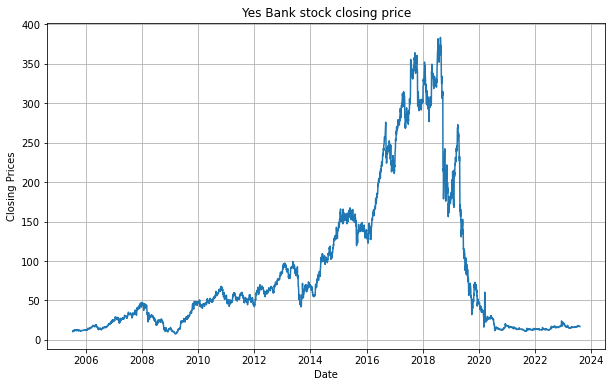

In [3]:
# Plot closing prices
Data_YesBank_ClosePrice = stock_data.drop(['Open','Low','High'], axis=1)

plt.figure(figsize=(10,6))
plt.grid()
plt.plot(Data_YesBank_ClosePrice)
plt.xlabel('Date')
plt.ylabel('Closing Prices')
plt.title('Yes Bank stock closing price')

In [4]:
type(Data_YesBank_ClosePrice)

pandas.core.frame.DataFrame

### b. Checking stationarity <a class="anchor" id="section_1_2"></a>
A time series is said to be stationary if its statistical properties such as mean, variance remain constant over time. The reason why we verify time series stationarity is because we cannot build a time series model if the time series is not stationary. Let's verify that the time series is stationary.

To do so, we will use the rolling statistics plots along with augmented Dickey-Fuller test results.

The Dickey-Fuller tests the null hypothesis that a unit root is present in a time series model. The alternative hypothesis is the stationarity of the model.


Note: 
The intuition behind the test is as follows. If the series y is stationary (or trend-stationary), then it has a tendency to return to a constant (or deterministically trending) mean. Therefore, large values will tend to be followed by smaller values (negative changes), and small values by larger values (positive changes). Accordingly, the level of the series will be a significant predictor of next period's change, and will have a negative coefficient. If, on the other hand, the series is integrated, then positive changes and negative changes will occur with probabilities that do not depend on the current level of the series; in a random walk, where you are now does not affect which way you will go next. (source: https://en.wikipedia.org/wiki/Dickey%E2%80%93Fuller_test)

# The following are the test hypotheses:



# Null hypothesis (H0): The time series data is non-stationary.


# Alternate hypothesis (H1): The time series is stationary (or trend-stationary).

In [5]:
def test_stationarity(timeseries):
    '''
    Input: timeseries (dataframe): timeseries for which we want to study the stationarity
    '''
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(20).mean()
    rolstd = timeseries.rolling(20).std()

    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend()
    plt.figure(figsize = (30,10))
    
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value',\
                                             '#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    
    

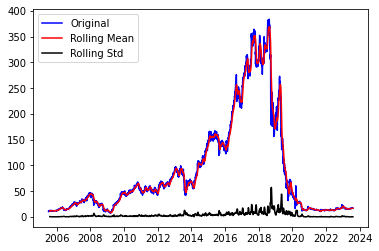

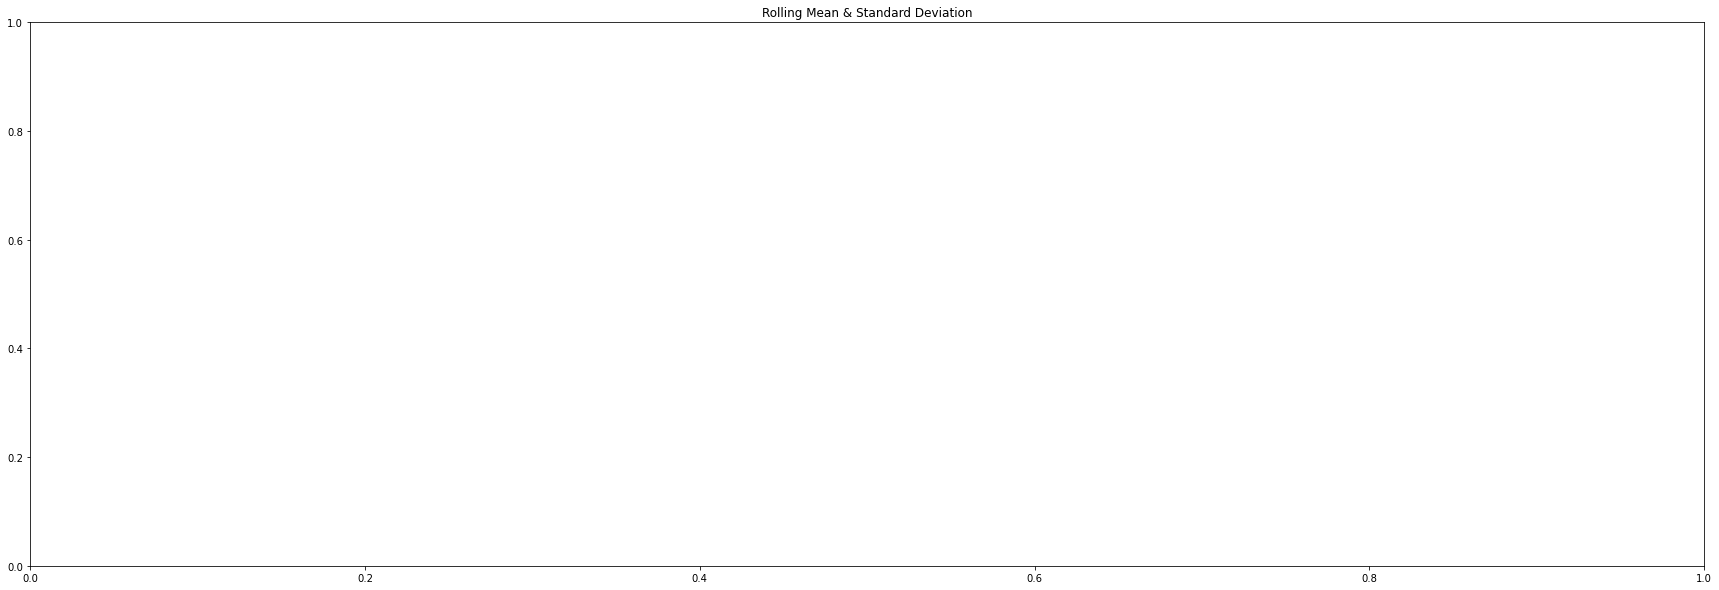

Results of Dickey-Fuller Test:
Test Statistic                   -1.519420
p-value                           0.523884
#Lags Used                       30.000000
Number of Observations Used    4430.000000
Critical Value (1%)              -3.431827
Critical Value (5%)              -2.862193
Critical Value (10%)             -2.567117
dtype: float64


In [6]:
#df_actual.set_index('Date',inplace=True)
test_stationarity(Data_YesBank_ClosePrice)

First, on the above graph, we can see that the rolling mean is increasing. Thus, the time series is not stationary.

The p-value is greater than the $5\%$ critical value, so the null hypothesis cannot be rejected.

Regarding the test statistic used in the augmented Dickey-Tuller statistic, it is a negative number. The more negative it is, the stronger the rejection of the hypothesis that there is a unit root at some level of confidence.

Here, -0.84 is greater than the -2.86 critical value at the $95\%$ confidence bound. Therefore, we can confirm that the null hypotheis cannot be rejected.

Let's apply some transformation to make our time series stationary.

### c. Making our time series stationary <a class="anchor" id="section_1_3"></a>


There are three major time series patterns: trend, seasonality, and cycles. Trend and cycles are usually combined into a single component, leaving us with a trend-cycle component, a seasonal component, and a remainder component (containing the rest of the time series).

To make our time series stationary, the principle is to estimate trend and seasonality, and to remove those from the time series. Then, we can apply the forecasting technique (i.e here LSTM), the final step being to convert the forcasted values into the original scale by adding the estimated trend and seasonality.

<Figure size 432x288 with 0 Axes>

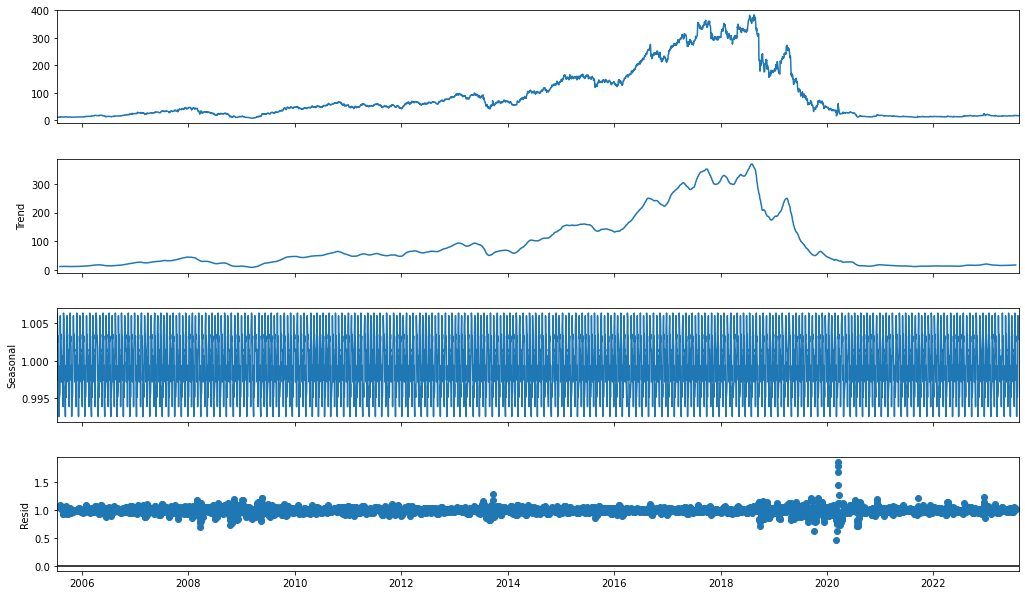

In [8]:
#To plot the trend and the seasonality
# We set the period to 28 as we have in average 7*4 = 28 days in a 
# month
# The result below is just to have a first visualization of trend and
# seasonality. Here we take a monthly average but to forecast a stock 
# price, it is more difficult than that to choose the right number of
# days to average on
result = seasonal_decompose(Data_YesBank_ClosePrice, model='multiplicative',period=30)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)

We start by estimating and eliminating trends. As the time series is constantly increasing, we apply a log transform, and a square root transform to flatten it.

Text(0.5, 1.0, 'Transformed data')

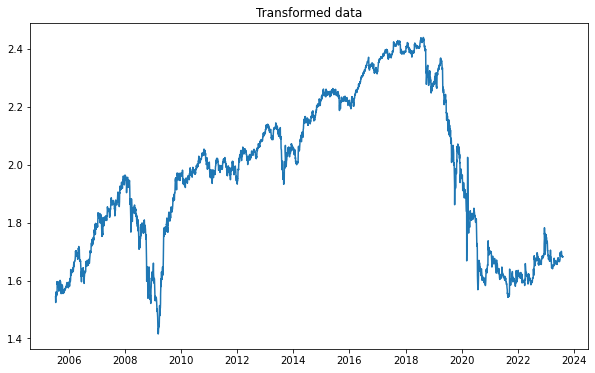

In [9]:
df_close_log = Data_YesBank_ClosePrice.apply(np.log)
df_close_tf = df_close_log.apply(np.sqrt)

plt.figure(figsize = (10,6))
plt.plot(df_close_tf)
plt.title('Transformed data')

In [10]:
df_close_tf

,Close
Date,
2005-07-12,1.544031
2005-07-13,1.532338
2005-07-14,1.524155
2005-07-15,1.549301
2005-07-18,1.560790
...,...
2023-08-03,1.683215
2023-08-04,1.682340
2023-08-07,1.681462


In [11]:
df_square=df_close_tf**2

Let's know use one classical method to deal with trend and seasonality: differenciating.
We take the difference of the observation at a particular instant with that at the previous instant.

In [13]:
df_exp=np.exp(df_square)
df_exp

,Close
Date,
2005-07-12,10.848566
2005-07-13,10.465256
2005-07-14,10.206745
2005-07-15,11.026850
2005-07-18,11.427988
...,...
2023-08-03,17.000000
2023-08-04,16.950001
2023-08-07,16.900000


In [ ]:
df_close_shift = df_close_tf - df_close_tf.shift()

df_close_shift.dropna(inplace=True)
plt.figure(figsize = (10,6))
test_stationarity(df_close_shift)

We obtain significally better results:

The test statistic is a lot lower than the critical value at 1%. Therefore, we can say with more than 99% confidence that this is a stationary series. Moreover, as the p-value is inferior to the 5% threshold, the null hypothesis is rejected, meaning that the Dickey-Fuller test is verified. Thus, the time series is stationary.

In [12]:
df_close_shift.to_csv('Yes_Bank_transformed_df')

In [13]:
#df=stock_data[['Close']]
def create_input_target(df):
    
    df.rename(columns = {'Close':'Input_1'}, inplace = True)
    df1=df.iloc[1:,:]
    df1.rename(columns = {'Input_1':'Input_2'}, inplace = True)
    df2=df1.iloc[1:,:]
    df2.rename(columns = {'Input_2':'Input_3'}, inplace = True)
    df3=df2.iloc[1:,:]
    df3.rename(columns = {'Input_3':'Target'}, inplace = True)

    df_actual=pd.DataFrame(pd.concat([df,df1,df2,df3],axis=1))
    df_actual['Input_2']=df_actual['Input_2'].shift(-1)
    df_actual['Input_3']=df_actual['Input_3'].shift(-2)
    df_actual['Target']=df_actual['Target'].shift(-3)

    df_actual=pd.DataFrame(df_actual.iloc[:-3,:])
    df_actual=df_actual.reset_index()
    return df_actual
df_actual= create_input_target(df_close_shift)
df_actual

C:\Users\44775\anaconda3\lib\site-packages\pandas\core\frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


,Date,Input_1,Input_2,Input_3,Target
0,2005-07-13,-0.011693,-0.008183,0.025146,0.011489
1,2005-07-14,-0.008183,0.025146,0.011489,-0.000751
2,2005-07-15,0.025146,0.011489,-0.000751,-0.002265
3,2005-07-18,0.011489,-0.000751,-0.002265,-0.005103
4,2005-07-19,-0.000751,-0.002265,-0.005103,-0.002329
...,...,...,...,...,...
4452,2023-07-31,0.000000,0.002617,-0.001741,0.000000
4453,2023-08-01,0.002617,-0.001741,0.000000,-0.000875
4454,2023-08-02,-0.001741,0.000000,-0.000875,-0.000878
4455,2023-08-03,0.000000,-0.000875,-0.000878,-0.000881


In [14]:
def windowed_df_to_date_X_y(windowed_dataframe):
  df_as_np = windowed_dataframe.to_numpy()

  dates = df_as_np[:, 0]

  middle_matrix = df_as_np[:, 1:-1]
  X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1))

  Y = df_as_np[:, -1]

  return dates, X.astype(np.float32), Y.astype(np.float32)

dates, X, y = windowed_df_to_date_X_y(df_actual)

dates.shape, X.shape, y.shape

((4457,), (4457, 3, 1), (4457,))

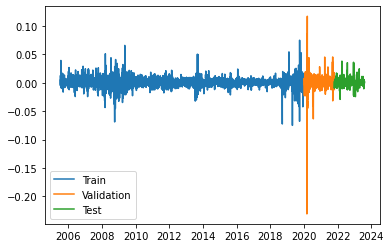

In [15]:
q_80 = int(len(dates) * .8)
q_90 = int(len(dates) * .9)

dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]

dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]
dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]

plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)

plt.legend(['Train', 'Validation', 'Test'])

In [16]:
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

print(y_train.shape)
print(y_test.shape)
print(y_val.shape)

(3565, 3, 1)
(446, 3, 1)
(446, 3, 1)
(3565,)
(446,)
(446,)
